In [1]:
%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")

In [24]:
from IPython.display import Image

import pandas as pd
from pandas import DataFrame
from math import isnan
import numpy,pickle
from numpy import load, save,append, array,percentile,hstack,mean,abs,equal
from sklearn.model_selection import cross_val_predict, ParameterGrid
from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.utils import shuffle
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn.decomposition import PCA, NMF
from sklearn.decomposition import RandomizedPCA as RCA
from sklearn.decomposition import KernelPCA as KCA


import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import dice,hamming,jaccard,kulsinski,matching,yule,rogerstanimoto
from scipy import stats
from scipy.stats import pointbiserialr as pointbiserial
from scipy.io import savemat

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,MACCSkeys,AtomPairs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs,Torsions
from rdkit.Chem.AtomPairs.Torsions import GetTopologicalTorsionFingerprintAsIntVect as TopologicalTorsionFingerPrint
from rdkit.Chem.Draw import IPythonConsole, SimilarityMaps
from rdkit.Chem.AtomPairs.Pairs import ExplainPairScore as ExplainAtomPairScore

In [5]:
def correlationMask(X,Y,topIndices):
    length = len(X)
    d = []
    for i in range(length):
        d+= [append(X[i][topIndices],Y[i]).tolist()]
    df = pd.DataFrame(d)
    correlation = df.corr()

    # Generate a mask for the upper triangle
    mask = numpy.zeros_like(correlation, dtype=numpy.bool)
    mask[numpy.triu_indices_from(mask)] = True
    
    return correlation, mask

def correlationPlot(correlation,mask):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return load(fullPath)


def saveNumpy(obj, name, path='.'):
    if ".npy" not in name:
        fullPath = path+'/'+name
        save(fullPath, obj)
        print name,'saved successfully in',path
    else:
        fullPath = path+'/'+name.split(".npy")[0]
        save(fullPath, obj)
        print name,'saved successfully in',path
        
def loadData(name,path='.'):
    '''
    This loads a pickle file and returns the content which is a DICTIONARY object in our case.
    '''
    if ".pkl" in name:
            name = name.split(".pkl")[0]
    if "/" in name:
            name = name.split("/",1)[1]

    with open(path+"/"+name + '.pkl', 'rb') as f:
          return pickle.load(f)
        
def saveData(obj, name,path='.'):
    '''
    This saves a object into a pickle file. In our case, it is generally a DICTIONARY object.
    '''

    with open(path+"/"+name + '.pkl', 'wb') as f:
            pickle.dump(obj, f)

In [13]:
atomIndices = loadNumpy('atompairTraining80-20Count')
maccsIndices = loadNumpy('atompairTraining80-20Count')

apCount = loadData('AtomPairFoldedCount')
apPositions = loadData('AtomPairPositions')

In [9]:
ap = loadNumpy('AtomPairCount')
HOMO = loadNumpy('HOMO')

In [16]:
actualAtomIndices = []
for index in atomIndices[:20]:
    actualAtomIndices += [apPositions[index]]

for i in range(len(actualAtomIndices))[:20]:
    print i,':',Pairs.ExplainPairScore(actualAtomIndices[i])

print 21,': HOMO'

0 : (('C', 2, 1), 5, ('N', 1, 2))
1 : (('C', 2, 2), 6, ('N', 3, 1))
2 : (('N', 3, 1), 7, ('N', 1, 2))
3 : (('C', 3, 1), 8, ('N', 1, 2))
4 : (('C', 3, 1), 11, ('N', 1, 2))
5 : (('C', 3, 1), 3, ('C', 3, 1))
6 : (('C', 3, 1), 5, ('C', 3, 1))
7 : (('C', 3, 1), 4, ('N', 1, 2))
8 : (('C', 3, 1), 8, ('C', 3, 1))
9 : (('C', 3, 1), 1, ('N', 3, 1))
10 : (('C', 2, 1), 3, ('N', 1, 2))
11 : (('C', 2, 1), 6, ('N', 1, 2))
12 : (('C', 3, 1), 7, ('N', 1, 2))
13 : (('C', 2, 2), 1, ('N', 1, 2))
14 : (('C', 2, 1), 5, ('C', 3, 1))
15 : (('C', 3, 1), 2, ('N', 1, 2))
16 : (('C', 3, 1), 2, ('C', 3, 1))
17 : (('C', 2, 1), 4, ('C', 2, 2))
18 : (('C', 3, 1), 9, ('C', 3, 1))
19 : (('C', 3, 1), 6, ('N', 1, 2))
21 : HOMO


What are these ? These are top features that determine the prediction of Atom Pairs. 

1. We can observe that most important features were (C,N) interactions especially that are further away from each other. 

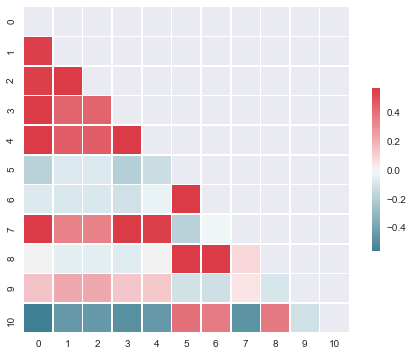

In [11]:
correlation, mask = correlationMask(ap,HOMO,atomIndices)
correlationPlot(correlation,mask)

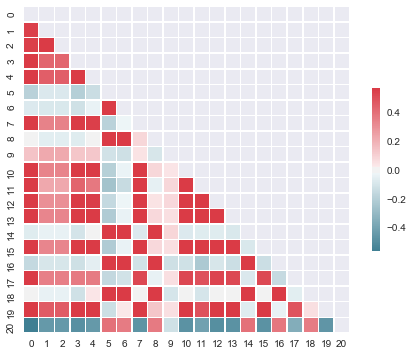

In [14]:
correlation, mask = correlationMask(ap,HOMO,atomIndices[:20])
correlationPlot(correlation,mask)

In [17]:
HOMOSorted= loadNumpy('HOMOSorted')
atomSorted= loadNumpy('atomSorted')
topoSorted= loadNumpy('topoSorted')
morganSorted= loadNumpy('morganSorted')
maccsSorted= loadNumpy('maccsSorted')
molsSorted= loadNumpy('molsSorted')

### Find common elements between best and worst HOMO

In [76]:
equality = []
for i in range(17):
    equality += [equal(atomSorted[-(2*i+1)],atomSorted[-(2*i+2)])]

In [43]:
from numpy import logical_and,logical_xor
logical_and(equality[0],equality[1])

array([ True,  True,  True, ...,  True, False,  True], dtype=bool)

In [77]:
final = logical_and(equality[0],equality[1])
for eq in equality[2:]:
    final = logical_and(final,eq)

In [68]:
len([i for i, x in enumerate(final) if x])

1400

In [88]:
equalityLow = []
for i in range(17):
    equalityLow += [equal(atomSorted[2*i],atomSorted[2*i+1])]
finalLow = logical_and(equalityLow[0],equalityLow[1])
for eq in equalityLow[2:]:
    finalLow = logical_and(finalLow,eq)

In [70]:
len([i for i, x in enumerate(finalLow) if x])

1630

In [71]:
len([i for i, x in enumerate(final) if x]),len([i for i, x in enumerate(finalLow) if x]),len([i for i, x in enumerate(logical_xor(final,finalLow)) if x])

(1400, 1630, 1120)

#### maccs

In [124]:
equality = []
for i in range(17):
    equality += [equal(maccsSorted[-(2*i+1)],maccsSorted[-(2*i+2)])]
finalHiMaccs = logical_and(equality[0],equality[1])
for eq in equality[2:]:
    finalHiMaccs = logical_and(finalHiMaccs,eq)
    
equalityLow = []
for i in range(17):
    equalityLow += [equal(maccsSorted[2*i],maccsSorted[2*i+1])]
finalLowMaccs = logical_and(equalityLow[0],equalityLow[1])
for eq in equalityLow[2:]:
    finalLowMaccs = logical_and(finalLowMaccs,eq)   

In [73]:
len([i for i, x in enumerate(final) if x]),len([i for i, x in enumerate(finalLow) if x]),len([i for i, x in enumerate(logical_xor(final,finalLow)) if x])

(74, 56, 22)

### Percentage of dissimilar indices between top 10% and bottom 10% of HOMO values

#### AtomPair

In [79]:
float(len([i for i, x in enumerate(logical_xor(final,finalLow)) if x]))/float(len(equality[0])) *100

41.85351270553064

### maccs

In [75]:
float(len([i for i, x in enumerate(logical_xor(final,finalLow)) if x]))/float(len(equality[0])) *100

13.253012048192772

There were many common elements between molecules with highest and lowest HOMO values. We will now attempt to find out what are the elements that are common between top features and these indices. Also for AtomPair, 41.83 % of features are not common between the highest and lowest HOMO values. Although, the fingerprints are very sparse representations, we can still identify many elements that are distinct, and these elements in turn impact the HOMO value of the molecule. 

Atom Indices contain the order of the most to least important features for the prediction. So we can match the indices of the ones which are similar to the top indices there. 

#### AtomPair

In [117]:
setHi = set(atomIndices[:35]) - set(final.nonzero()[0])

In [118]:
indices = finalLow.nonzero()[0]
setLo = set(atomIndices[:35]) - set(finalLow.nonzero()[0])

In [121]:
differenceImpFeatures = list(setLo ^ setHi)

In [120]:
apCount = loadData('AtomPairFoldedCount')
apPositions = loadData('AtomPairPositions')

In [122]:
actualIndices = []
for index in differenceImpFeatures:
    actualIndices += [apPositions[index]]

for i in range(len(actualIndices)):
    print i,':',Pairs.ExplainPairScore(actualIndices[i])

0 : (('N', 1, 2), 8, ('O', 1, 0))
1 : (('N', 1, 2), 8, ('O', 1, 1))
2 : (('C', 2, 2), 12, ('N', 1, 2))
3 : (('C', 2, 2), 6, ('N', 3, 1))
4 : (('N', 1, 2), 4, ('N', 1, 2))
5 : (('N', 3, 1), 7, ('N', 1, 2))
6 : (('C', 3, 1), 8, ('N', 1, 2))


#### maccs

In [134]:
maccsIndices = loadNumpy('maccsTraining80-20Count')

In [135]:
setHiMaccs = set(maccsIndices[:35]) - set(finalHiMaccs.nonzero()[0])
setLoMaccs = set(maccsIndices[:35]) - set(finalLowMaccs.nonzero()[0])

In [140]:
setLoMaccs-setHiMaccs

{23, 55, 62, 70}

In [145]:
differenceImpFeatures = list(setLoMaccs ^ setHiMaccs)
for i in differenceImpFeatures:
    print i+1 ## adjustment for indices starting from 1 in MACCSKeys

71
24
56
63
